# Отбор признаков в задачах машинного обучения. Статистические методы.  

Часто наборы данных, с которыми приходится работать, содержат большое количество признаков, число которых может достигать нескольких сотен и даже тысяч. При построении модели машинного обучения не всегда понятно, какие из признаков действительно для неё важны (т.е. имеют связь с целевой переменной), а какие являются избыточными (или шумовыми). Удаление избыточных признаков позволяет лучше понять данные, а также сократить время настройки и обучения модели, улучшить её точность и облегчить интерпретируемость. Иногда эта задача и вовсе может быть самой значимой, например, нахождение оптимального набора признаков может помочь расшифровать механизмы, лежащие в основе исследуемой проблемы. Это может быть полезным для разработки различных методик, например, банковского скоринга, поиска фрода или медицинских диагностических тестов. Обычно методы отбора признаков делят на 3 категории: статистические методы или фильтры (filters), встроенные алгоритмы (embedded algorithms) и методы обёртки (wrappers). В настоящем цикле статей приведён обзор некоторых из этих методов с обсуждением их достоинств, недостатков и особенностей реализации.  
   
## Статистические методы (фильтры)

Статистические методы применяются до обучения модели и как правило имеют низкую стоимость вычислений. Они основаны на визуальном анализе (например, удаление признака, у которого только одно значение, или большинство значений пропущено), оценке признаков с помощью какого-нибудь статистического критерия (дисперсии, корреляции, $\chi^2$ и др.) и экспертной оценке (удаление признаков, которые не подходят по смыслу – например, «цвет галстука заёмщика» в задаче кредитного скоринга 😊). 

Простейшим способом оценки пригодности признаков является разведочный анализ данных (например, с библиотекой [pandas-profiling](https://newtechaudit.ru/uskoryaem-analiz-dannyh-c-pomoshhyu-pandas-profiling/)). При больших размерах датасета эту задачу можно автоматизировать с помощью библиотеки [feature-selector](https://github.com/WillKoehrsen/feature-selector), которая отбирает признаки по следующим параметрам:
- Количество пропущенных значений (удаляются признаки у которых процент пропущенных значений больше порогового значения).
- Коэффициент корреляции (удаляются признаки, у которых коэффициент корреляции больше порогового значения).
- Вариативность (удаляются признаки, состоящие из одного значения).
- Оценка важности признаков с помощью lightgbm (удаляются признаки, имеющие низкую важность в модели lightgbm. Следует применять только если модель lightgbm имеет хорошую точность.)

Туториал по этой библиотеке находится [здесь](https://github.com/WillKoehrsen/feature-selector/blob/master/).

Более сложные методы автоматического отбора признаков реализованы в sklearn. [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold) отбирает признаки, у которых дисперсия меньше заданного значения. [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) и [SelectPercentile](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile) оценивают взаимосвязь предикторов с целевой переменной используя статистические методы, позволяя отобрать соответственно заданное количество и долю наилучших признаков. Методы отбора основаны на F-тестах (обозначаются `f_regression` и `f_classif` соответственно для регрессии и классификации), оценке функции взаимной информации (`mutual_info_regression` и `mutual_info_classif`) и $\chi^2$ (`chi2` для классификации). F-тесты хорошо работают только с линейными зависимостями, поэтому лучше всего они подойдут для линейной регрессии, а $\chi^2$-тесты требуют неотрицательных и правильно отмасштабированных признаков. Поэтому удобнее всего использовать методы, основанные на вычислении взаимной информации – они почти не требуют настройки и позволяют находить нелинейные связи.
Рассмотрим применение статистических методов в реальной [задаче](https://archive.ics.uci.edu/ml/datasets/Adult) – предсказать, зарабатывает ли человек больше $50 тыс. Загрузим библиотеки и данные, для удобства оставив только численные признаки:
- age – возраст
- fnlwgt (final weight) – примерная оценка количества людей, которое представляет каждая строка данных
- educational-num – длительность обучения
- capital-gain – прирост капитала
- capital-loss – потеря капитала
- hours-per-week – количество рабочих часов в неделю

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# зафиксируем значение генератора случайных чисел для воспроизводимости 
SEED = 1

df = pd.read_csv(r'..\adult.data.csv')

# датасет, с которым будем работать
# оставим только численые признаки
X = df.select_dtypes(exclude=['object']).copy()
# преобразуем целевую переменную
y = df['salary'].map({'<=50K':0, '>50K':1}).values

X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [2]:
X.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


В качестве классификатора будем использовать случайный лес. Посмотрим точность на кросс-валидации и важность признаков:

scores = [0.82427915 0.82290796 0.83106668 0.8192637  0.83155106] 
mean score = 0.82581 +/- 0.00478


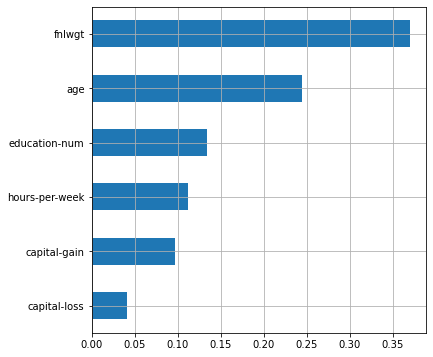

In [3]:
model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=SEED)
# параметры кросс-валидации (стратифицированная 5-фолдовая с перемешиванием) 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scores = cross_val_score(estimator=model, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

# важность признаков
model.fit(X, y)
(pd.DataFrame(data=model.feature_importances_, index=X.columns).sort_values(by=0)
                                                               .plot(kind='barh', grid=True,
                                                                     figsize=(6,6), legend=False));

Самым важным признаком в нашей модели является fnlwgt. Это можно интерпретировать как то, что главным фактором того, что человек зарабатывает больше $50 тыс. является количество людей с такими же характеристиками. Такая интерпретация выглядит нелогичной, а происходит это потому, что "деревянные" модели (случайный лес и бустинг) могут выдавать сильно смещённую оценку признаков (подробнее [здесь](https://explained.ai/rf-importance/)). Притом, чем хуже настроена модель, тем сильнее может быть смещение, поэтому доверять оценкам таких моделей надо с осторожностью. 

Создадим 12 «шумовых» признаков, элементами которых будут некоррелируемые случайные числа из выборок с нормальным, равномерным и Лапласовым распределениями. Параметры каждого распределения подбираются случайным образом независимо друг от друга.

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,norm_0,unif_0,lapl_0,norm_1,unif_1,lapl_1,norm_2,unif_2,lapl_2,norm_3,unif_3,lapl_3
0,39,77516,13,2174,0,40,0.246454,4.996750,2.311467,6.474587,6.431455,-0.932124,3.773136,3.382773,-1.324387,8.031167,2.142457,8.050902
1,50,83311,13,0,0,13,-4.656718,4.693542,2.095298,14.622329,2.795007,6.465348,-3.275117,3.787041,0.652694,7.537461,5.247103,9.014559
2,38,215646,9,0,0,40,12.788669,4.255611,22.278713,9.643720,3.533265,2.716441,4.725608,3.126107,23.410698,1.932907,4.933431,13.233319
3,53,234721,7,0,0,40,-15.713848,3.989797,5.971506,8.978198,7.772238,-5.402306,5.742672,3.084132,0.937932,9.435720,4.915537,-3.396526
4,28,338409,13,0,0,40,20.703306,3.159246,8.718559,8.217148,4.365603,14.403088,3.023828,6.934299,4.978327,7.355296,2.551361,10.479218


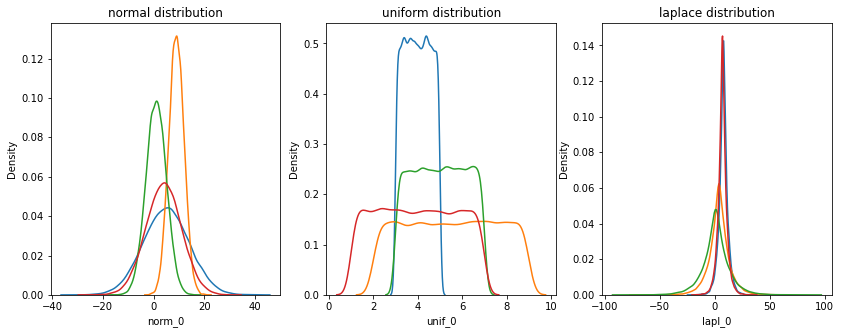

In [4]:
# утановим значение генератора случайных чисел для воспроизводимости
np.random.seed(SEED)

fix, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
ax1.set_title("normal distribution")
ax2.set_title("uniform distribution")
ax3.set_title("laplace distribution")
for i in range(4):
    X.loc[:, f'norm_{i}'] = np.random.normal(loc=np.random.randint(low=0, high=10), 
                                             scale=np.random.randint(low=1, high=10), 
                                             size=(X.shape[0], 1))
    
    X.loc[:, f'unif_{i}'] = np.random.uniform(low=np.random.randint(low=1, high=4), 
                                              high=np.random.randint(low=5, high=10), 
                                              size=(X.shape[0], 1))
    X.loc[:, f'lapl_{i}'] = np.random.laplace(loc=np.random.randint(low=0, high=10), 
                                              scale=np.random.randint(low=1, high=10), 
                                              size=(X.shape[0], 1))
    # визуализирукем распределения признаков
    sns.kdeplot(X[f'norm_{i}'], ax=ax1)
    sns.kdeplot(X[f'unif_{i}'], ax=ax2)
    sns.kdeplot(X[f'lapl_{i}'], ax=ax3)

# итоговый датасет
X.head()

Проведём кросс-валидацию на зашумлённых данных и посмотрим важность признаков: 

scores = [0.8522425  0.85382173 0.86249657 0.84897581 0.85443027] 
mean score = 0.85439 +/- 0.00447


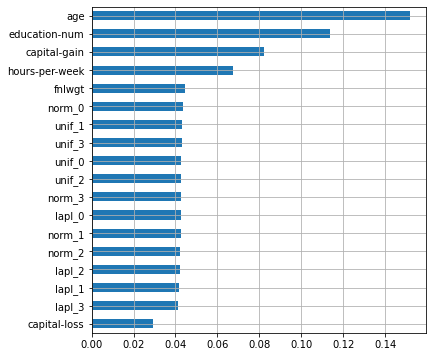

In [5]:
scores = cross_val_score(estimator=model, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))
model.fit(X, y)
(pd.DataFrame(data=model.feature_importances_, index=X.columns).sort_values(by=0)
                                                               .plot(kind='barh', grid=True,
                                                                     figsize=(6,6), legend=False));

Несмотря на большое количество добавленных шумовых признаков, точность модели на кросс-валидации значительно возросла как на каждом фолде, так и в среднем! Кроме этого, шумовые признаки имеют высокую важность, сравнимую с двумя оригинальными. Очевидно, что наша модель переобучена, однако в реальных задачах такие ситуации бывает очень сложно распознать, особенно когда при удалении некоторых признаков (про которые неизвестно – шумовые они, или нет) падает валидационная точность. 
Проведём отбор признаков статистическими методами, для чего будем использовать обобщённый вариант `SelectKBest` и `SelectPercentile`, который называется [GenericUnivariateSelect](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html#sklearn.feature_selection.GenericUnivariateSelect). Он принимает на вход 3 параметра – функцию оценки, режим отбора и его параметры. В качестве функции оценки будем использовать метод, основанный на вычислении взаимной информации. 

In [6]:
selector = GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=6)
# применим к нашему датасету
selector.fit(X, y)
# метод transform вернёт массив с отобраными признаками
# выведем результаты оценки каждого признака 
pd.DataFrame(data={'score':selector.scores_,
                   'support':selector.get_support()}, 
                    index=X.columns).sort_values(by='score',ascending=False)

,score,support
capital-gain,0.080221,True
age,0.065703,True
education-num,0.064743,True
hours-per-week,0.043655,True
capital-loss,0.033617,True
fnlwgt,0.033390,True
norm_3,0.003217,False
unif_3,0.002696,False
norm_0,0.002506,False
norm_2,0.002052,False


Сгенерированные нами признаки имеют низкое значение оценочной функции (`scores_`), поэтому в дальнейшем селектор не будет их использовать (`get_support()=False`). 

В реальной задаче (когда количество шумовых признаков неизвестно) параметры `GenericUnivariateSelect` можно находить на кросс-валидации вместе с другими гиперпараметрами модели. Посмотрим, как изменится точность нашего классификатора после подбора параметров случайного леса и количества признаков селектора:

In [7]:
# модель с селектором
model_w_selector = Pipeline([('selector', GenericUnivariateSelect(score_func=mutual_info_classif,
                                                                  mode='k_best')),
                             ('rf', RandomForestClassifier(n_jobs=-1,
                                                           class_weight='balanced',
                                                           random_state=SEED))
                            ])
# grid search
gs_params = {'selector__param': np.arange(4,9),
             'rf__max_depth': np.arange(2, 18, 2),
             'rf__max_features': np.arange(0.3, 0.9, 0.2)}

gs = GridSearchCV(estimator=model_w_selector, param_grid=gs_params, refit=True,
                  scoring='roc_auc', n_jobs=-1, cv=skf, verbose=0)
gs.fit(X, y)

# предсказания тестовой выборки на cv модели с лучшими параметрами
scores = [gs.cv_results_[f'split{i}_test_score'][gs.best_index_] for i in range(5)]
print('scores = {}, \nmean score = {:.5f} +/- {:.5f} \
      \nbest params = {}'.format(scores,
                                 gs.cv_results_['mean_test_score'][gs.best_index_],
                                 gs.cv_results_['std_test_score'][gs.best_index_],
                                 gs.best_params_))

scores = [0.8632776968200635, 0.8683443340928604, 0.8710308000627435, 0.8615748939138762, 0.8693334091828478], 
mean score = 0.86671 +/- 0.00364       
best params = {'rf__max_depth': 12, 'rf__max_features': 0.3, 'selector__param': 5}


Точность на кросс-валидации значительно выросла, а лучший результат получился всего для 5 признаков. Посмотрим на них:

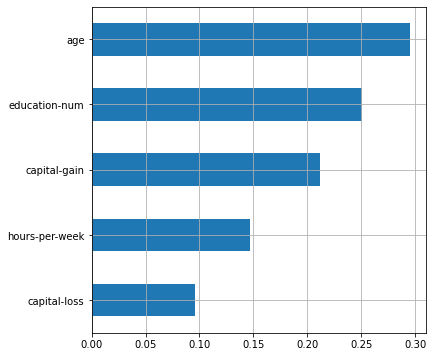

In [8]:
# выведем признаки, отобранные селектором
selected_features = [X.columns[i] for i, support
                     in enumerate(gs.best_estimator_['selector'].get_support()) if support]
# важность признаков
(pd.DataFrame(gs.best_estimator_['rf'].feature_importances_, 
              index=selected_features).sort_values(by=0)
                                      .plot(kind='barh', grid=True,
                                            figsize=(6,6),legend=False)); 

Таким образом лучший результат был получен после удаления шумовых признаков и признака fnlwgt, который при первоначальной оценке был самым значимым для модели. Однако из всех оригинальных признаков он имел наименьшее значение оценочной функции в `GenericUnivariateSelect`. Результаты оценки важности признаков после отбора имеют более логичную интерпретацию – на заработок человека влияют именно характеристики человека, а не параметры самой выборки. Таким образом статистический отбор признаков бывает полезен для увеличения точности модели и получения менее смещённой оценки при интерпретации её результатов.

## Заключение.

В статье были рассмотрены некоторые статистические методы отбора признаков. К их достоинствам можно отнести низкую стоимость вычислений (линейно зависит от количества признаков) и хорошую интерпретируемость. К недостаткам – то, что они рассматривают каждый признак изолировано, поэтому не могут выявить более сложные зависимости в данных, например, зависимость целевой переменой от нескольких предикторов. Кроме того, в некоторых случаях даже небольшое изменение признака (или наличие непустых значений) может быть само по себе очень важным, поэтому к результатам отбора следует относиться критически и по возможности проводить экспертный анализ. Более сложные методы отбора признаков будут рассмотрены в следующих статьях цикла.
